In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please unzip the archive using suitable path to the fruit dataset archive
!unzip "/content/drive/MyDrive/fruit dataset/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

#Importing Libraries

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from skimage import feature
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math

#Function to extract the color Histogram

The color distribution of the images is represented by Color Histogram.

The Color Histogram will be used as the first part of feature vector.


In [ ]:
def color_hist(img, bins = (10, 10, 10)):

  # Resizing the input image
  img = cv2.resize(img, (100, 100))
  
  # Calculating the histogram
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0, 180, 0, 256, 0, 256])
  
  # Normalising the Histogram
  cv2.normalize(hist, hist)
  
  # Returning the flattened histogram
  return np.array(hist.flatten())

# Function to calculate HOG of the image

The edges of the images is represented by Histogram of Gradients.

The HOG will be used as the second part of feature vector.

In [ ]:
def HOG_Calculate(image):

  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  # Flattening the HOG before returning
  return np.array(hog_image.flatten())

In [ ]:
def show_Hog_Image(image):
  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  plt.imshow((hog_image*255)[...,::-1])

#Creating the KNN Classifier class

*   It is based on supervised Learning technique.
*   This algorithm finds the similarity between the new data and the training data and then put the new data into the category which is most similar to the training data categories.







In [ ]:
# Implement the KNN algorithm classifier without using the sklearn library
class KNNClassifier:

  # Constructor Function for our class
    def __init__(self, k=5):

        self.k = k  # by default k = 5
        self.X_train = None # class prototypes
        self.y_train = None # labels
        self.isFirst = True
        self.pre_dis = dict()
    

    # Training Function 
    def fit(self, X, y):

        # make sure that X is a 2D array and Y is a 1D array else raise an error 
        if len(X.shape) != 2 and len(y.shape) != 1:
            raise Exception("Error: X must be a 2D array")

        self.X_train = X
        self.y_train = y
    
    # Optimized predict function for HyperTuning using a fixed validation set
    def hyper_tuning_predict(self, X, method='U'):
        # Method parameter decides if we want to do a weighted (W) prediction or an unweighted (U) prediction
        # By default, we do an unweighted prediction
        if len(X.shape) != 2:
          raise Exception("Error: X must be a 2D array")
        
        if(str(method).lower() != 'u' and str(method).lower() != 'w'):
          raise Exception("Error: Please select a valid method : (U/W)")
        
        y_pred = []

        if(str(method).lower() == 'u'):
          for i in range(len(X)):
              # predicting the labels of all the feacture vector one by one
              label = self.hyper_tuning_predict_one(X[i], i)
              y_pred.append(label)
        else:
          for i in range(len(X)):
              # predicting the labels of all the feacture vector one by one
              label = self.hyper_tuning_predict_one_Weighted(X[i], i)
              y_pred.append(label)
        self.isFirst = False
        return y_pred

    # Unweighted Single Prediction Method for HyperTuning
    def hyper_tuning_predict_one(self, row, j):

      if(self.isFirst):
        for i in range(len(self.X_train)):
          dist = self.distance(row, self.X_train[i])
          if(self.pre_dis.get(j) != None):
            self.pre_dis[j].append((dist, self.y_train[i]))
          else:
            self.pre_dis[j] = [(dist, self.y_train[i])]

        # Sorting the distance array 
        self.pre_dis[j].sort()

      neighbors = self.pre_dis[j][:self.k]

      weights = dict()
      freq = dict()
      maxfreq = 0
      
      # Calculating the Weights

      for i in range(len(neighbors)):
        label = neighbors[i][1]
        if weights.get(label) is not None:
          weights[label] += neighbors[i][0]
          freq[label] += 1
        else:
          weights[label] = neighbors[i][0]
          freq[label] = 1
        
        maxfreq = max(maxfreq, freq[label])
      
      minWeight = -1
      answer_label = 0

      # Finding the label with minimum weight.
      # Weight of a label is basically the sum of all distances from datapoints of that label
      # This significanty decreases the chances of a Tie.
      for key, val in weights.items():
        if((minWeight == -1 or minWeight > val) and freq[key] == maxfreq):
          answer_label = key
          minWeight = val

      return answer_label

      #Extracting labels of k nearest neighbor
      labels = [neighbor[1] for neighbor in neighbors]
      return max(set(labels), key=labels.count)
    

    # Weighted Single Prediction method for hyperTuning
    def hyper_tuning_predict_one_Weighted(self, row, j):
      
      if(self.isFirst):
        for i in range(len(self.X_train)):
          dist = self.distance(row, self.X_train[i])
          if(self.pre_dis.get(j) != None):
            self.pre_dis[j].append((dist, self.y_train[i]))
          else:
            self.pre_dis[j] = [(dist, self.y_train[i])]
        
        # Sorting the distance array 
        self.pre_dis[j].sort()

      neighbors = self.pre_dis[j][:self.k]

      # Weight of neighbours
      weights = dict()

      # Calculating the Weights
      for i in range(len(neighbors)):
        label = neighbors[i][1]
        if weights.get(label) is not None:
          weights[label] += neighbors[i][0]
        else:
          weights[label] = neighbors[i][0]
      
      minWeight = -1
      answer_label = 0

      # Finding the label with minimum weight.
      # Weight of a label is basically the some of all distances from datapoints of that label
      # This significanty decreases the chances of a Tie.
      for key, val in weights.items():
        if(minWeight == -1 or minWeight > val):
          answer_label = key
          minWeight = val

      return answer_label


    # Function to predict the labels of array of Image
    def predict(self, X, method='U'):
        # Method parameter decides if we want to do a weighted (W) prediction or an unweighted (U) prediction
        # By default, we do an unweighted prediction
        if(str(method).lower() != 'u' and str(method).lower() != 'w'):
          raise Exception("Error: Please select a valid method : (U/W)")

        # make sure that X is a 2D array else return an error
        if len(X.shape) != 2:
            raise Exception("Error: X must be a 2D array")

        # Predictions array
        y_pred = []

        if(str(method).lower() == 'u'):
          for row in X:
              # predicting the labels of all the feacture vector one by one
              label = self.predict_one(row)
              y_pred.append(label)
        else:
          for row in X:
              # predicting the labels of all the feacture vector one by one
              label = self.predict_one_Weighted(row)
              y_pred.append(label)
        
        return y_pred
    
    # Predict the label of a single Image
    def predict_one(self, row):
        
        # Distance array
        distances = []

        # Looping over the feature vector
        for i in range(len(self.X_train)):
            dist = self.distance(row, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Sorting the distance array 
        distances.sort()

        # Extracting first k neighbors
        neighbors = distances[:self.k]

        weights = dict()
        freq = dict()
        maxfreq = 0
        
        # Calculating the Weights

        for i in range(len(neighbors)):
          label = neighbors[i][1]
          if weights.get(label) is not None:
            weights[label] += neighbors[i][0]
            freq[label] += 1
          else:
            weights[label] = neighbors[i][0]
            freq[label] = 1
          
          maxfreq = max(maxfreq, freq[label])
        
        minWeight = -1
        answer_label = 0

        # Finding the label with minimum weight.
        # Weight of a label is basically the sum of all distances from datapoints of that label
        # This significanty decreases the chances of a Tie.
        for key, val in weights.items():
          if((minWeight == -1 or minWeight > val) and freq[key] == maxfreq):
            answer_label = key
            minWeight = val

        return answer_label

        #Extracting labels of k nearest neighbor
        # labels = [neighbor[1] for neighbor in neighbors]


        # return max(set(labels), key=labels.count)
    
    # Precit the label of a feature vector based on weighted KNN
    def predict_one_Weighted(self, row):
        
        # Distance array
        distances = []

        # Looping over the feature vector
        for i in range(len(self.X_train)):
            dist = self.distance(row, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Sorting the distance array 
        distances.sort()

        # Extracting first k neighbors
        neighbors = distances[:self.k]

        # Weight of neighbours
        weights = dict()
        
        # Calculating the Weights
        for i in range(len(neighbors)):
          label = neighbors[i][1]
          if weights.get(label) is not None:
            weights[label] += neighbors[i][0]
          else:
            weights[label] = neighbors[i][0]
        
        minWeight = -1
        answer_label = 0

        # Finding the label with minimum weight.
        # Weight of a label is basically the sum of all distances from datapoints of that label
        # This significanty decreases the chances of a Tie.
        for key, val in weights.items():
          if(minWeight == -1 or minWeight > val):
            answer_label = key
            minWeight = val

        return answer_label
    
    # Function to find Euclidian distance between two feature vector
    def distance(self, a, b):
        return np.linalg.norm(a - b)

#Extracting All Images and their Features from the Dataset


In [ ]:
# Root Directory for the Training Images Folder
rootdir = './fruits-360_dataset/fruits-360/Training'

# Features array
features = []

# Labels array
imageLables = []

# Looping over all the subdirectories, directories, and files in the Root directory
for subdir, dir, files in os.walk(rootdir):

  imagecnt = 0
  
  # Looping over the images
  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the label from the image name
    imageLables.append(str(subdir).split('/')[-1])

    # Calculating the color histogram of the image
    colorDistribution = color_hist(img, (10, 10, 10))

    # Calculating the HOG for our image
    hogDistribution = HOG_Calculate(img)

    # Concatenating the above 2 form a feature and add that 2 the feature array
    features.append(np.concatenate((colorDistribution, hogDistribution))) 

    imagecnt += 1

    # Sampling the training dataset with maximum 200 images per class
    if imagecnt > 100:
      break
  # if imagecnt > 500:
  #   break
    
# Converting the lists into numpy arrays for better performance
features = np.array(features)
imageLables = np.array(imageLables)

Splitting the data into train and test set

In [ ]:
(train_x_f, test_x_f, train_y_f, test_y_f) = train_test_split(features, imageLables, test_size = 0.2, random_state = 42)

##Calculating best K : 
Preliminary Testing for Hyper-Parameter (k) tuning using unweighted Predictions

In [ ]:
max_accuracy = 0
accuracies_unweighted = []

# Creating a Model based on our manual implementation
model = KNNClassifier(1)

for k in range(3, 11):
    # train the model using the best k value and the training set
    model.k = k
    model.fit(train_x_f, train_y_f)
    # predict the labels on the test set using the model
    predictions = model.hyper_tuning_predict(test_x_f, method='U')
    # calculate the accuracy of the model using predictions and actual labels
    accuracy = accuracy_score(test_y_f, predictions)

    accuracies_unweighted.append(accuracy)
    # print the accuracy of the model
    print(f"k = %d, accuracy = {accuracy}" % (k))
    # keep track of the best accuracy
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        neighbours = k

best_k_unweighted = neighbours


k = 3, accuracy = 0.9686437476388364
k = 4, accuracy = 0.9637325273894976
k = 5, accuracy = 0.9463543634302984
k = 6, accuracy = 0.9410653570079335
k = 7, accuracy = 0.9236871930487344
k = 8, accuracy = 0.9195315451454477
k = 9, accuracy = 0.9051756705704571
k = 10, accuracy = 0.9013978088401965


Preliminary Testing for Hyper-Parameter (k) tuning using weighted Predictions using same model as above since it has pre calculated the distance array

In [ ]:
max_accuracy = 0
accuracies_weighted = []
for k in range(3, 11):
    # train the model using the best k value and the training set
    model.k = k
    model.fit(train_x_f, train_y_f)
    # predict the labels on the test set using the model
    predictions = model.hyper_tuning_predict(test_x_f, method='W')
    # calculate the accuracy of the model using predictions and actual labels
    accuracy = accuracy_score(test_y_f, predictions)

    accuracies_weighted.append(accuracy)
    # print the accuracy of the model
    print(f"k = %d, accuracy = {accuracy}" % (k))
    # keep track of the best accuracy
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        neighbours = k

best_k_weighted = neighbours

k = 3, accuracy = 0.9482432942954288
k = 4, accuracy = 0.9115980355119002
k = 5, accuracy = 0.8530411786928599
k = 6, accuracy = 0.7967510389119759
k = 7, accuracy = 0.7468832640725349
k = 8, accuracy = 0.6849263316962599
k = 9, accuracy = 0.6339251983377409
k = 10, accuracy = 0.5950132225160559


Freeing Memory

In [ ]:
import gc
del model.pre_dis
model.isFirst = True
gc.collect()

94

Creating weighted and unweighted model on their best K

In [ ]:
model_unweighted = KNNClassifier(best_k_unweighted)
model_weighted = KNNClassifier(best_k_weighted)

In [ ]:
model_unweighted.fit(train_x_f, train_y_f)
model_weighted.fit(train_x_f, train_y_f)

Plotting the accuracy for different K Values

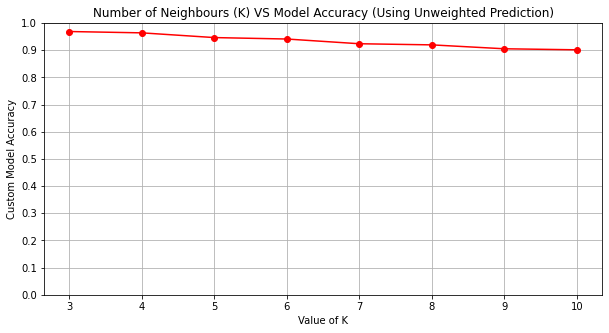

In [ ]:
x = np.array([3,4,5,6,7,8,9,10])
y = np.array(accuracies_unweighted)
f = plt.figure()

f.set_figheight(5)
f.set_figwidth(10)

plt.plot(x,y, zorder=2, color = "red")
plt.scatter(x,y, zorder=4, color = "red")
plt.grid(True, zorder=0)

plt.xticks(x)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Value of K")
plt.ylabel("Custom Model Accuracy")
plt.title('Number of Neighbours (K) VS Model Accuracy (Using Unweighted Prediction)')
plt.show()

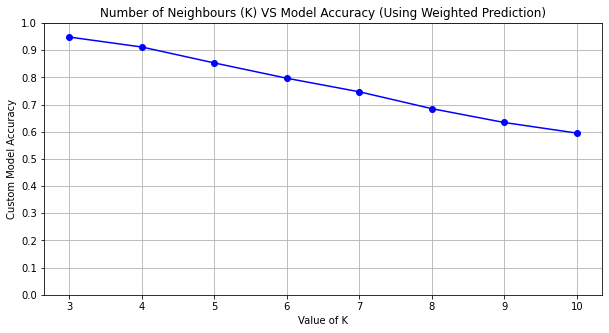

In [ ]:
x = np.array([3,4,5,6,7,8,9,10])
y = np.array(accuracies_weighted)
f = plt.figure()

f.set_figheight(5)
f.set_figwidth(10)

plt.plot(x,y, zorder=2, color = "blue")
plt.scatter(x,y, zorder=4, color = "blue")
plt.grid(True, zorder=0)

plt.xticks(x)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Value of K")
plt.ylabel("Custom Model Accuracy")
plt.title('Number of Neighbours (K) VS Model Accuracy (Using Weighted Prediction)')
plt.show()

##Calculating best K for scikitLearn KNeighborsClassifier: 
Preliminary Testing for Hyper-Parameter (k) tuning

In [ ]:
max_accuracy = 0
accuracies = []
for k in range(3, 11):
    # train the model using the best k value and the training set
    model_skLearn = KNeighborsClassifier(n_neighbors = k, n_jobs = 2)
    model_skLearn.fit(train_x_f, train_y_f)
    # predict the labels on the test set using the model
    predictions = model_skLearn.predict(test_x_f)
    # calculate the accuracy of the model using predictions and actual labels
    accuracy = accuracy_score(test_y_f, predictions)

    accuracies.append(accuracy)
    # print the accuracy of the model
    print(f"k = %d, accuracy = {accuracy}" % (k))
    # keep track of the best accuracy
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        neighbours = k

model_skLearn = KNeighborsClassifier(n_neighbors = neighbours, n_jobs = 2)
model_skLearn.fit(train_x_f, train_y_f)

k = 3, accuracy = 0.960710238005289
k = 4, accuracy = 0.9471099357763506
k = 5, accuracy = 0.9387986399697771
k = 6, accuracy = 0.9236871930487344
k = 7, accuracy = 0.915753683415187
k = 8, accuracy = 0.9010200226671704
k = 9, accuracy = 0.8923309406875708
k = 10, accuracy = 0.8813751416698149


KNeighborsClassifier(n_jobs=2, n_neighbors=3)

Plotting the accuracy for different K Values

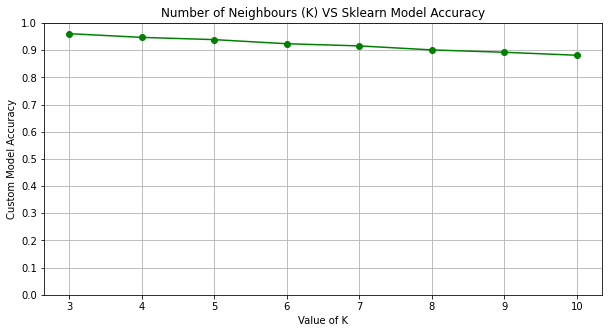

In [ ]:
x = np.array([3,4,5,6,7,8,9,10])
y = np.array(accuracies)
f = plt.figure()

f.set_figheight(5)
f.set_figwidth(10)

plt.plot(x,y, zorder=2, color = "green")
plt.scatter(x,y, zorder=4, color = "green")
plt.grid(True, zorder=0)

plt.xticks(x)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Value of K")
plt.ylabel("Custom Model Accuracy")
plt.title('Number of Neighbours (K) VS Sklearn Model Accuracy')
plt.show()

# Comparing Sklean model VS Weighted Predictions (Manual Implementation) VS Unweighted Predictions (Manual Implementation)

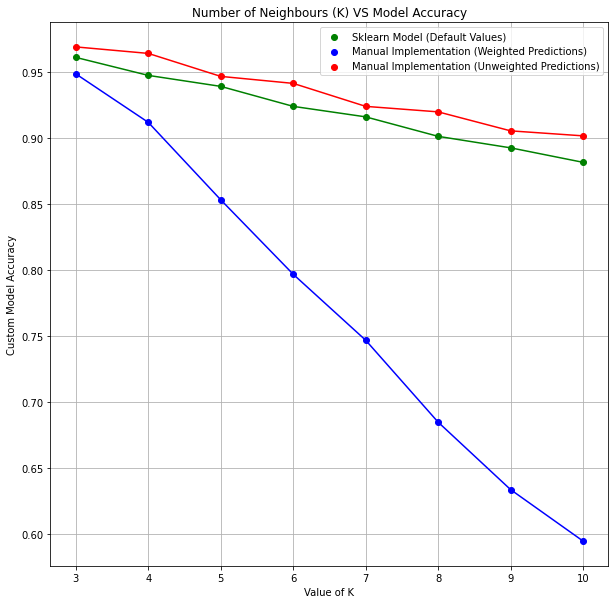

In [ ]:
x = np.array([3,4,5,6,7,8,9,10])
y = np.array(accuracies)
y2 = np.array(accuracies_weighted)
y3 = np.array(accuracies_unweighted)
f = plt.figure()

f.set_figheight(10)
f.set_figwidth(10)

plt.plot(x,y, zorder=2, color = "green")
plt.plot(x, y2, zorder=2, color = 'blue')
plt.plot(x, y3, zorder=2, color = 'red')
plt.scatter(x,y, zorder=4, color = "green", label='Sklearn Model (Default Values)')
plt.scatter(x,y2, zorder=4, color = "blue", label='Manual Implementation (Weighted Predictions)')
plt.scatter(x,y3, zorder=4, color = "red", label='Manual Implementation (Unweighted Predictions)')
plt.grid(True, zorder=0)

plt.xticks(x)
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Value of K")
plt.ylabel("Custom Model Accuracy")
plt.title('Number of Neighbours (K) VS Model Accuracy')
plt.legend(loc=1)
plt.show()

##Saving the model

In [ ]:
import pickle
# SAVING THE MODEL
filename = 'KNN_Custom_unweigted_100_3.sav'
pickle.dump(model_unweighted, open(filename, 'wb'))

filename = 'KNN_Custom_weigted_100_3.sav'
pickle.dump(model_weighted, open(filename, 'wb'))

filename2 = 'KNN_skLearn_100_3.sav'
pickle.dump(model_skLearn, open(filename2, 'wb'))

#Checking The models on a test Image

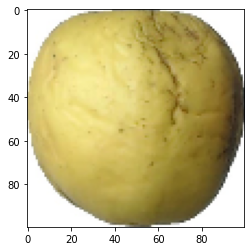

In [ ]:
# Path of the Image
imagePath = "./fruits-360-original-size/fruits-360-original-size/Training/apple_golden_1/r0_0.jpg"

# Reading the Image
testImage = cv2.resize(cv2.imread(imagePath), (100, 100))

plt.imshow(testImage[:,:,::-1])

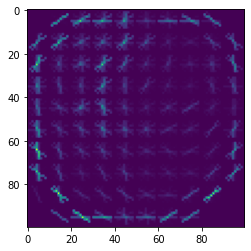

In [ ]:
# We are plotting using matplotlib which is showing distorted colors. 
# But the 2 colors are sufficient to correctly visualize the HOG.
show_Hog_Image(testImage)

In [ ]:
# Calculating the Feature vector for this test image
colorDistribution = np.array(color_hist(testImage, (10, 10, 10)))
hogDistribution = np.array(HOG_Calculate(testImage))

# Feature Vector
feature_array = np.array([np.concatenate((colorDistribution, hogDistribution))])

# Predicting the Label for the image
prediction_unweighted = model_unweighted.predict(feature_array, method = 'U')
prediction_weighted = model_weighted.predict(feature_array, method = 'W')
prediction_skLearn = model_skLearn.predict(feature_array)

# Printing the Predictions
print(f"Model which was trained on original labels predicted it to be {prediction_unweighted} based on custom unweighted model.")
print(f"Model which was trained on original labels predicted it to be {prediction_weighted} based on custom weighted model.")
print(f"Model which was trained on original labels predicted it to be {prediction_skLearn} based on skLearn model.")

Model which was trained on original labels predicted it to be ['Apple Golden 2'] based on custom unweighted model.
Model which was trained on original labels predicted it to be ['Apple Golden 2'] based on custom weighted model.
Model which was trained on original labels predicted it to be ['Apple Golden 2'] based on skLearn model.


#Extensive Testing on Final Test Images to check the desired Metrics

In [ ]:
# Root Directory where the Test Images are stored
rootdir = './fruits-360_dataset/fruits-360/Test'

# Features array
features_TEST = []
# Real Labels array
imageLables_TEST = []



for subdir, dir, files in os.walk(rootdir):

  imagecnt = 0

  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the Label
    imageLables_TEST.append(str(subdir).split('/')[-1])

    # Calculating the Color Distribution and HOG of the image
    colorDistribution = color_hist(img, (10, 10, 10))
    hogDistribution = HOG_Calculate(img)

    # Appending the Feature Vector of our Image into the Features array
    features_TEST.append(np.concatenate((colorDistribution, hogDistribution)))

    imagecnt += 1

    if imagecnt > 50:
      break
  # if imagecnt > 50:
  #   break

# Converting the Feature array and the Image Labels array into numpy array for better performance
features_TEST = np.array(features_TEST)
imageLables_TEST = np.array(imageLables_TEST)

# Checking Accuracy on all Test Images

In [ ]:
# Predicting the labels using both the models

prediction_unweighted = model_unweighted.predict(features_TEST, method = 'U')
prediction_weighted = model_weighted.predict(features_TEST, method = 'W')
prediction_skLearn = model_skLearn.predict(features_TEST)

# Function to extract Metrics from classification Report

In [ ]:
def getMetricsFromReport(report):
  # Classification Report has to be generated via classification_report imported from sklearn.metrics
  # For successful parsing
  r = report.split('\n')[-2].split()
  answer = []
  for i in r:
    try:
      answer.append(float(i.strip()))
    except Exception as e:
      pass
  print(r)
  print(answer)
  (p, rec, f1, sup) = answer
  return (p, rec, f1, sup)

#Printing the Classification Report of Custom Model

In [ ]:
report_unweighted = classification_report(prediction_unweighted, imageLables_TEST)
print(report_unweighted)

                     precision    recall  f1-score   support

     Apple Braeburn       0.67      0.83      0.74        41
 Apple Crimson Snow       0.98      0.64      0.78        78
     Apple Golden 1       0.76      0.95      0.85        41
     Apple Golden 2       0.88      0.88      0.88        51
     Apple Golden 3       0.96      0.77      0.85        64
 Apple Granny Smith       1.00      0.85      0.92        60
    Apple Pink Lady       0.67      0.64      0.65        53
        Apple Red 1       0.71      1.00      0.83        36
        Apple Red 2       0.75      0.78      0.76        49
        Apple Red 3       0.61      1.00      0.76        31
Apple Red Delicious       0.86      0.96      0.91        46
 Apple Red Yellow 1       0.80      0.91      0.85        45
 Apple Red Yellow 2       0.31      1.00      0.48        16
            Apricot       0.63      0.94      0.75        34
            Avocado       0.67      0.85      0.75        40
       Avocado ripe    

In [ ]:
report_weighted = classification_report(prediction_weighted, imageLables_TEST)
print(report_weighted)

                     precision    recall  f1-score   support

     Apple Braeburn       0.61      0.84      0.70        37
 Apple Crimson Snow       0.94      0.69      0.79        70
     Apple Golden 1       0.61      0.91      0.73        34
     Apple Golden 2       0.92      0.84      0.88        56
     Apple Golden 3       0.98      0.86      0.92        58
 Apple Granny Smith       0.73      0.82      0.77        45
    Apple Pink Lady       0.53      0.49      0.51        55
        Apple Red 1       0.71      0.92      0.80        39
        Apple Red 2       0.65      0.77      0.70        43
        Apple Red 3       0.55      0.97      0.70        29
Apple Red Delicious       0.78      0.98      0.87        41
 Apple Red Yellow 1       0.88      0.96      0.92        47
 Apple Red Yellow 2       0.41      1.00      0.58        21
            Apricot       0.59      0.88      0.71        34
            Avocado       0.71      0.77      0.73        47
       Avocado ripe    

#Printing the Classification Report of skLearn Model

In [ ]:
report_skLearn = classification_report(prediction_skLearn, imageLables_TEST)
print(report_skLearn)

                     precision    recall  f1-score   support

     Apple Braeburn       0.67      0.77      0.72        44
 Apple Crimson Snow       0.98      0.58      0.73        86
     Apple Golden 1       0.78      0.95      0.86        42
     Apple Golden 2       0.88      0.79      0.83        57
     Apple Golden 3       0.96      0.75      0.84        65
 Apple Granny Smith       1.00      0.84      0.91        61
    Apple Pink Lady       0.69      0.56      0.61        63
        Apple Red 1       0.73      0.95      0.82        39
        Apple Red 2       0.75      0.78      0.76        49
        Apple Red 3       0.61      1.00      0.76        31
Apple Red Delicious       0.84      0.96      0.90        45
 Apple Red Yellow 1       0.80      0.89      0.85        46
 Apple Red Yellow 2       0.37      1.00      0.54        19
            Apricot       0.65      0.92      0.76        36
            Avocado       0.67      0.83      0.74        41
       Avocado ripe    

In [ ]:
p_unweighted, rec_unweighted, f1_unweighted, sup_unweighted = getMetricsFromReport(report_unweighted)

['weighted', 'avg', '0.81', '0.77', '0.77', '6681']
[0.81, 0.77, 0.77, 6681.0]


In [ ]:
p_weighted, rec_weighted, f1_weighted, sup_weighted = getMetricsFromReport(report_weighted)

['weighted', 'avg', '0.77', '0.73', '0.73', '6681']
[0.77, 0.73, 0.73, 6681.0]


In [ ]:
p_skLearn, rec_skLearn, f1_skLearn, sup_skLearn = getMetricsFromReport(report_skLearn)

['weighted', 'avg', '0.80', '0.76', '0.76', '6681']
[0.8, 0.76, 0.76, 6681.0]


Printing Overall Accuracies

In [ ]:
print(f"The Overall Accuracy of Custom Unweighted Model is {accuracy_score(imageLables_TEST, prediction_unweighted)*100}%")
print(f"The Overall Accuracy of Custom Weighted Model is {accuracy_score(imageLables_TEST, prediction_weighted)*100}%")
print(f"The Overall Accuracy skLearn Model is {accuracy_score(imageLables_TEST, prediction_skLearn)*100}%")

The Overall Accuracy of Custom Unweighted Model is 77.00942972608891%
The Overall Accuracy of Custom Weighted Model is 73.19263583295914%
The Overall Accuracy skLearn Model is 75.61742254153569%


#Plotting Comparison Curves Curve (Because it's Fun!)

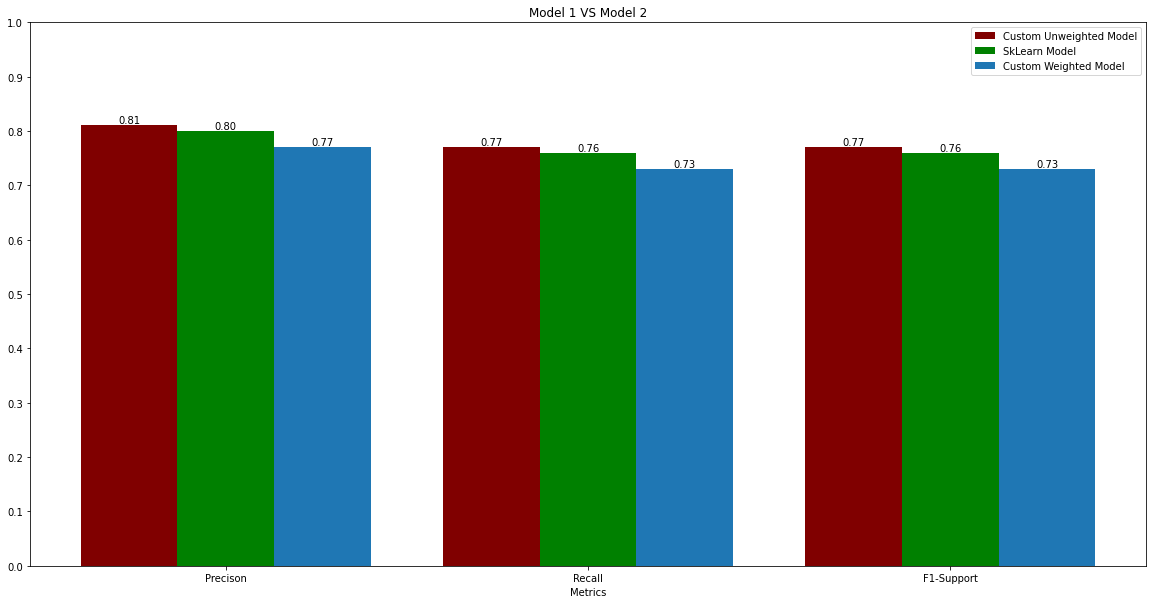

In [ ]:
X = ['Precison', 'Recall', 'F1-Support']
Y_1 = [p_unweighted, rec_unweighted, f1_unweighted]
Y_2 = [p_skLearn, rec_skLearn, f1_skLearn]
Y_3 = [p_weighted, rec_weighted, f1_weighted]

X_Axis = np.arange(3, 12, 3)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(20)

b1 = plt.bar(X_Axis - 0.8, Y_1, 0.8, label = 'Custom Unweighted Model', color='maroon', zorder=3)
b2 = plt.bar(X_Axis , Y_2, 0.8, label = 'SkLearn Model', color = 'green', zorder=3)
b3 = plt.bar(X_Axis + 0.8, Y_3, 0.8, label = 'Custom Weighted Model', zorder=3)


for rect in b1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')


for rect in b2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for rect in b3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')



plt.xticks(X_Axis, X)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Metrics")
plt.title("Model Comparison")
plt.legend(loc=1)

plt.show()